# Elliptical Slice Sampling without mean shifting in Numpy
This code is largely based on the code found [here](https://gist.github.com/adiehl96/d586d13ac47d7f2a3e98142b2c436ef5), which is based on the youtube video by Viking Penguin found [here](https://www.youtube.com/watch?v=HfzyuD9_gmk). However, any mention of the mean in the sampling method was removed, as it's not necessarily part of it.

# Assumptions
* The sampler assumes that the prior is a gaussian (This can be seen in the sampling step where we have to sample from a multivariate gaussian distribution).
* The sampler assumes a prior with a zero mean, as the mean is not mentioned in this implementation.


100%|██████████| 10999/10999 [00:17<00:00, 625.01it/s]


sampled_mean 2.033596274437791 true_mean 2.0


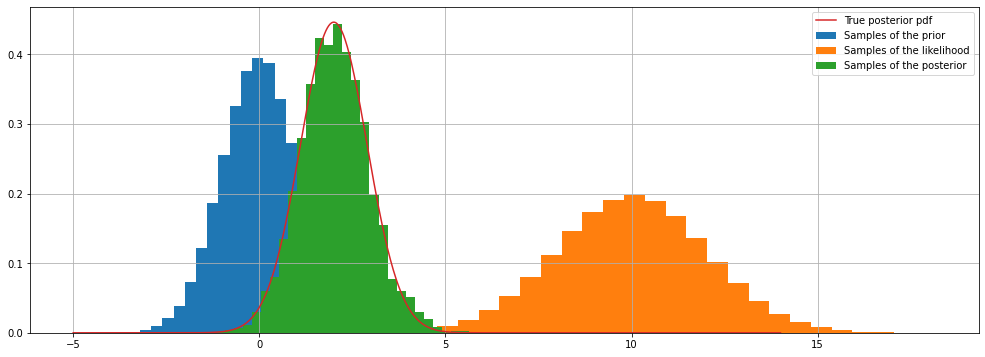

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

np.random.seed(8)


class EllipticalSliceSampler:
  """Elliptical Slice Sampler Class
  
  The elliptical slice sampling algorithm is a Markov chain Monte Carlo
  approach to sampling from posterior distributions that consist of an
  arbitrary likelihood times a multivariate normal prior. The elliptical
  slice sampling algorithm is advantageous because it is conceptually simple 
  and easy to implement and because it has no free parameters.

  The algorithm operates by randomly selecting a candidate from an ellipse
  defined by two vectors, one of which is assumed to be drawn from the target
  posterior and another that is an auxiliary random sample of a zero-mean
  multivariate normal. The algorithm iteratively shrinks the range from which
  candidates can be drawn until a candidate proposal is accepted.
  """
  def __init__(self, covariance, log_likelihood_func):
    """Initialize the parameters of the elliptical slice sampler object.

    Parameters:
      mean (numpy array): A mean vector of a multivariate Gaussian.
      covariance (numpy array): A two-dimensional positive-definite
        covariance matrix of a multivariate Gaussian.
      log_likelihood_func (function): A log-likelihood function that maps
      a given sample (as its exclusive input) to a real number
      reflecting the log-likelihood of the observational data under
      the input parameter.
    """
    self.covariance = covariance
    self.log_likelihood_func = log_likelihood_func

  def __sample(self, f):
    """Internal Function that draws an individual sample according to the
    elliptical slice sampling routine. The input is drawn from the target
    distribution and the output is as well.

    Parameters:
      f (numpy array): A vector representing a parameter state that has
      been sampled from the target posterior distribution. Note that
      a sufficently high 'burnin' parameter can be leveraged to
      achieve a good mixin for this purpose.
    """
    # Choose the ellipse for this sampling iteration.
    nu = np.random.multivariate_normal(np.zeros(self.covariance.shape[:1]), self.covariance)
    # print("nu", nu, nu.shape)
    # Set the candidate acceptance treshold.
    log_y = self.log_likelihood_func(f) + np.log(np.random.uniform())
    # Set the bracket for selecting candidates on the ellipse.
    theta = np.random.uniform(0., 2.*np.pi)
    theta_min, theta_max = theta - 2.*np.pi, theta

    # Iterates until a candidate is selected.
    while True:
      # Generates a point on the ellipse defined by 'nu' and the input. We
      # also compute the log-likelihood of the candidate and compare to
      # our threshold.
      fp = (f)*np.cos(theta) + nu*np.sin(theta)
      log_fp = self.log_likelihood_func(fp)
      if log_fp > log_y:
        return fp
      else:
        # If the candidate is not selected, shrink the bracket and
        # generate a new 'theta', which will yield a new candidate
        # point on the ellipse.
        if theta < 0.:
          theta_min = theta
        else:
          theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
      
  def sample(self, n_samples, current_state, burnin=1000):
    """This function is user-facing and is used to generate a specified
    number of samples from the target distribution using elliptical slice
    sampling. The 'burnin' parameter defines how many iterations should be
    performed (and excluded) to achieve convergence to the target
    distribution.

    Parameters:
      n_samples (int): The number of samples to produce from this sampling
        routine.
      burnin (int, optional): The number of burnin iterations to perform.
        This is necessary to achieve samples that are representative of
        the true posterior and correctly characterize uncertainty.
    """
    # Compute the total number of samples.
    total_samples = n_samples + burnin
    # Initialize a matrix to store the samples. The first sample is chosen
    # to be a draw from the multivariate normal prior.
    samples = np.zeros((total_samples, self.covariance.shape[0]))
    samples[0] = current_state
    for i in tqdm(range(1, total_samples)):
      samples[i] = self.__sample(samples[i-1])
    return samples[burnin:]

def main():
  # Set the mean and variance of two Gaussian densities. The first of these will be
  # regarded as the prior, while the second will represent the likelihood.
  # Fortunately, the product of two Gaussian densities can be regarded as an
  # Unnormalized Gaussian density with closed-form expressions for the mean
  # and variance.
  prior_mean = 0.
  prior_variance = 1.
  likelihood_mean = 10.
  likelihood_variance = 2.
  posterior_mean = ((prior_variance**-2)*prior_mean + (likelihood_variance**-2)*likelihood_mean) / (prior_variance**-2 + likelihood_variance**-2)
  posterior_variance = np.sqrt((prior_variance**2 * likelihood_variance**2) / (prior_variance**2 + likelihood_variance**2))

  # define the log-likelihood function.
  def log_likelihood_func(f):
    return norm.logpdf(f, likelihood_mean, likelihood_variance)

  # Now perform sampling from the "posterior" using elliptical slice sampling.
  n_samples = 10000
  sampler = EllipticalSliceSampler(np.diag(np.array([prior_variance**2, ])), 
                                   log_likelihood_func)
  samples = sampler.sample(n_samples, 
                           current_state=np.random.multivariate_normal(mean=np.zeros(1), cov=np.array([[prior_variance ]])),
                           burnin=1000)
  print("sampled_mean", np.mean(samples), "true_mean", posterior_mean)

  # Visualize the samples and compare to the true "posterior"
  r = np.linspace(-5., 14., num=1000)
  plt.figure(figsize=(17,6))
  plt.hist(np.random.normal(prior_mean, prior_variance, size=200000), bins=30, density=True, label = "Samples of the prior")
  plt.hist(np.random.normal(likelihood_mean, likelihood_variance, size=200000), bins=30, density=True, label = "Samples of the likelihood")

  plt.hist(samples, bins=30, density=True, label = "Samples of the posterior")
  plt.plot(r, norm.pdf(r, posterior_mean, posterior_variance), label = "True posterior pdf")
  plt.grid()
  plt.legend()
  plt.show()

main()